In [1]:
# load calibration matrix, ground-truth labels, and sample image
# detect objects in image using ground-truth labels or fine-tuned YOLOv8 model
# load point cloud
# downsample point cloud
# segment point cloud using RANSAC algorithm
# project points onto image plane
# extract frustums
# for each frustum:
    # cluster labels
    # generate 3d bounding boxes
    # visualize predictions
    # evaluate predictions

In [2]:
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from pathlib import Path

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import utils
import calibration_utils

import importlib
importlib.reload(utils)
importlib.reload(calibration_utils)

<module 'calibration_utils' from '/home/tom/Documents/UNT/csce6260/projects/kitti-experiments/fusion/calibration_utils.py'>

### Load data

In [4]:
base = Path.home() / "kitti"
train_dir = base / "training"
train_img_dir = train_dir / "image_2"
kitti_images_train = sorted(train_img_dir.glob("*.png"))
train_labels_dir = train_dir / "label_2"
kitti_train_labels = sorted(train_labels_dir.glob("*.txt"))
velo_dir = train_dir / "velodyne"
point_cloud_train_files = sorted(velo_dir.glob("*.bin"))
calib_dir = train_dir / "calib"
calib_train_files = sorted(calib_dir.glob("*.txt"))

Sample Image Path: /home/tom/kitti/training/image_2/005902.png



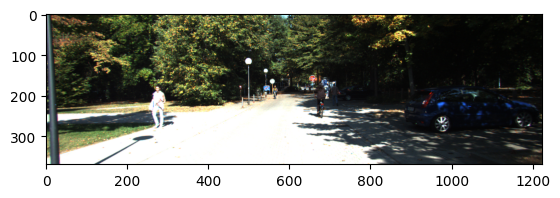

In [5]:
analysis_file_index = 5902
sample_image_path = kitti_images_train[analysis_file_index]
print(f"Sample Image Path: {sample_image_path}\n")
sample_image = cv2.imread(sample_image_path)
sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
plt.imshow(sample_image_rgb)

In [6]:
bin_path = point_cloud_train_files[analysis_file_index]
print("Sample Cloud File Path: {}\n".format(bin_path))
points_velo = utils.read_velodyne_bin(bin_path)
print('--> .bin File Content\n')
print(points_velo[:3])

Sample Cloud File Path: /home/tom/kitti/training/velodyne/005902.bin

--> .bin File Content

[[77.704  0.169  2.837  0.   ]
 [78.408  1.649  2.861  0.   ]
 [77.905  4.089  2.847  0.   ]]


In [7]:
calib = utils.parse_calib_file(calib_train_files[analysis_file_index])
print("Calibration data:")
print(calib)

Calibration data:
{'P0': array([[707.0493,   0.    , 604.0814,   0.    ],
       [  0.    , 707.0493, 180.5066,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]], dtype=float32), 'P1': array([[ 707.0493,    0.    ,  604.0814, -379.7842],
       [   0.    ,  707.0493,  180.5066,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]], dtype=float32), 'P2': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02,  4.575831e+01],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02, -3.454157e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.981016e-03]],
      dtype=float32), 'P3': array([[ 7.070493e+02,  0.000000e+00,  6.040814e+02, -3.341081e+02],
       [ 0.000000e+00,  7.070493e+02,  1.805066e+02,  2.330660e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  3.201153e-03]],
      dtype=float32), 'R0': array([[ 0.9999128 ,  0.01009263, -0.00851193],
       [-0.01012729,  0.9999406 , -0.00403767],
       [ 0.00847067,  0.00412352,  0.9999556 ]], dtype=

### Output ground-truth 2d object detections

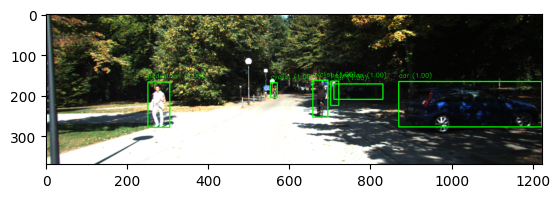

In [8]:
def get_gt_detections(labels):
    gt_detections = []
    for label in labels:
        class_name = label["type"].lower()
        if class_name != "dontcare":
            x_min, y_min, x_max, y_max = label["bbox_2d"]
            gt_detections.append({
                "bounding_box": [x_min, y_min, x_max, y_max],
                "object_name": class_name.lower(),
                "confidence": float(1.0)
            })
    return gt_detections


sample_label = utils.parse_label_file(kitti_train_labels[analysis_file_index])
gt_detections = get_gt_detections(sample_label)
gt_image = utils.draw_detection_output(sample_image_rgb, gt_detections, color_rgb=(0, 255, 0))
plt.imshow(gt_image);

### Extract frustums

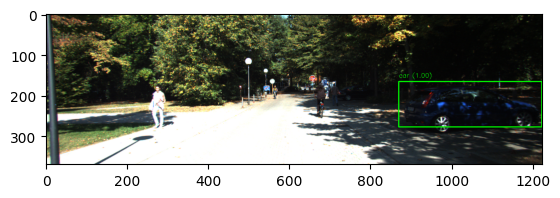

In [9]:
def get_gt_car_detections(gt_detections):
    gt_car_detections = [det for det in gt_detections if det['object_name'] == 'car']
    return gt_car_detections

gt_car_detections = get_gt_car_detections(gt_detections)
gt_car_detection = gt_car_detections[0]
gt_image = utils.draw_detection_output(sample_image_rgb, [gt_car_detection], color_rgb=(0, 255, 0))
plt.imshow(gt_image);

In [10]:
points_img_coords = calibration_utils.convert_to_img_coords(points_velo, calib)
u = points_img_coords[:, 0]
v = points_img_coords[:, 1]

valid_mask = np.isfinite(u) & np.isfinite(v)
xmin, ymin, xmax, ymax = gt_car_detection['bounding_box']
mask_car = (u >= xmin) & (u <= xmax) & (v >= ymin) & (v <= ymax)
mask_in_front = points_velo[:, 0] > 0
mask_car = mask_car & valid_mask & mask_in_front

frustum_points = points_velo[mask_car]
frustum_points

array([[ 53.701, -24.411,   0.393,   0.   ],
       [ 53.803, -24.355,   0.393,   0.   ],
       [ 54.091, -24.281,   0.394,   0.   ],
       ...,
       [ 11.007,  -4.084,  -1.601,   0.28 ],
       [ 11.014,  -4.047,  -1.6  ,   0.37 ],
       [ 11.047,  -4.02 ,  -1.603,   0.31 ]],
      shape=(2613, 4), dtype=float32)

In [11]:
frustum_cloud = o3d.geometry.PointCloud()
frustum_cloud.points = o3d.utility.Vector3dVector(frustum_points[:, :3])
o3d.visualization.draw_geometries([frustum_cloud], width=1600, height=900)